# Deep Learning for Content-Based Filtering

In this exercise, you will implement content-based filtering using a neural network to build a recommender system for movies.

# Outline
- [ 1 - Packages](#1)
- [ 2 - Movie ratings dataset](#2)
  - [ 2.1 Content-based filtering with a neural network](#2.1)
  - [ 2.2 Preparing the training data](#2.2)
- [ 3 - Neural Network for content-based filtering](#3)
- [ 4 - Congratulations!](#4)


<a name="1"></a>
## 1 - Packages
We will use familiar packages, NumPy, TensorFlow and helpful routines from [scikit-learn](https://scikit-learn.org/stable/). We will also use [tabulate](https://pypi.org/project/tabulate/) to neatly print tables and [Pandas](https://pandas.pydata.org/) to organize tabular data.

In [ ]:
import numpy as np
import numpy.ma as ma
from numpy import genfromtxt
from collections import defaultdict
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
pd.set_option("display.precision", 1)

<a name="2"></a>
## 2 - Movie ratings dataset
The data set is derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset.

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The original dataset has 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has $n_u = 395$ users and $n_m= 694$ movies. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy|IMAX".  This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below.

<a name="2.1"></a>
### 2.1 Content-based filtering with a neural network

You generated two vectors, a user vector and an item/movie vector whose dot product would predict a rating. The vectors were derived solely from the ratings.   

Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.



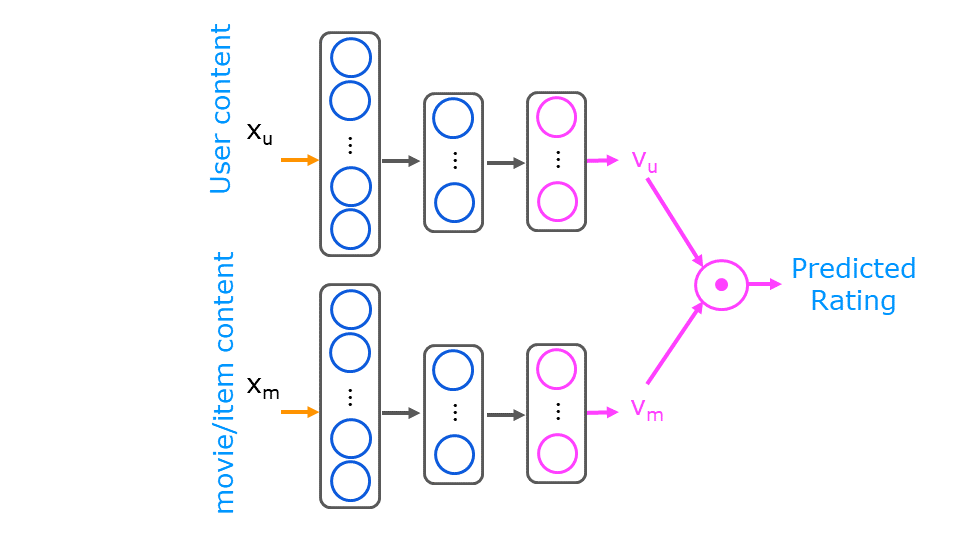
The movie content provided to the network is a combination of the original data and some 'engineered features'. Recall the feature engineering discussion and lab from Course 1, Week 2, lab 4. The original features are the year the movie was released and the movie's genre presented as a one-hot vector. There are 14 genres. The engineered feature is an average rating derived from the user ratings. Movies with multiple genre have a training vector per genre.

The user content is composed of only engineered features. A per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available, but are not included in the training or prediction content. They are useful in interpreting data.

The training set consists of all the ratings made by the users in the data set. The user and movie/item vectors are presented to the above network together as a training set. The user vector is the same for all the movies rated by the user.

Below, let's load and display some of the data.

In [ ]:
# Load Data, set configuration variables
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
scaledata = True  # applies the standard scalar to data if true
print(f"Number of training vectors: {len(item_train)}")

Some of the user and item/movie features are not used in training. Below, the features in brackets "[]" such as the "user id", "rating count" and "rating ave" are not included when the model is trained and used. Note, the user vector is the same for all the movies rated.

In [ ]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)

In [ ]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

In [ ]:
print(f"y_train[:5]: {y_train[:5]}")

Above, we can see that movie 6874 is an action movie released in 2003. User 2 rates action movies as 3.9 on average. Further, movie 6874 was also listed in the Crime and Thriller genre. MovieLens users gave the movie an average rating of 4. A training example consists of a row from both tables and a rating from y_train.

<a name="2.2"></a>
### 2.2 Preparing the training data
We will use feature scaling as a means of improving convergence and for that we will scale the input features using the [scikit learn StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Below, the inverse_transform is also shown to produce the original inputs.

In [ ]:
# scale training data
if scaledata:
    item_train_save = item_train
    user_train_save = user_train

    scalerItem = StandardScaler()
    scalerItem.fit(item_train)
    item_train = scalerItem.transform(item_train)

    scalerUser = StandardScaler()
    scalerUser.fit(user_train)
    user_train = scalerUser.transform(user_train)

    print(np.allclose(item_train_save, scalerItem.inverse_transform(item_train)))
    print(np.allclose(user_train_save, scalerUser.inverse_transform(user_train)))

To allow us to evaluate the results, we will split the data into training and test sets. Here we will use [sklean train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split and shuffle the data. Note that setting the initial random state to the same value ensures item, user, and y are shuffled identically.

In [ ]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test  data shape: {item_test.shape}")

The scaled, shuffled data now has a mean of zero.

In [ ]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

Scale the target ratings using a Min Max Scaler to scale the target to be between -1 and 1. We use scikit-learn because it has an inverse_transform. [scikit learn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [ ]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(y_train.reshape(-1, 1))
ynorm_train = scaler.transform(y_train.reshape(-1, 1))
ynorm_test = scaler.transform(y_test.reshape(-1, 1))
print(ynorm_train.shape, ynorm_test.shape)

<a name="3"></a>
## 3 - Neural Network for content-based filtering
Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.

- Use a Keras sequential model
    - The first layer is a dense layer with 256 units and a relu activation.
    - The second layer is a dense layer with 128 units and a relu activation.
    - The third layer is a dense layer with `num_outputs` units and a linear or no activation.   
    
The remainder of the network will be provided. The provided code does not use the Keras sequential model but instead uses the Keras [functional api](https://keras.io/guides/functional_api/). This format allows for more flexibility in how components are interconnected.


In [ ]:
# GRADED_CELL
# UNQ_C1

num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
    ### END CODE HERE ###
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
    ### END CODE HERE ###
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features, ))
vu = user_NN(input_user)
vu = tf.keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vu)
# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features, ))
vm = item_NN(input_item)
vm = tf.keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = Model([input_user, input_item], output)

model.summary()

In [ ]:
# Public tests
from public_tests import *
test_tower(user_NN)
test_tower(item_NN)

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
  You can create a dense layer with a relu activation as shown.
    
```python     
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),

    
    ### END CODE HERE ###  
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),

    
    ### END CODE HERE ###  
])
```    
</details>

    


# We'll use a mean squared error loss and an Adam optimizer.

In [ ]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [ ]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], ynorm_train, epochs=30)

Evaluate the model to determine loss on the test data. It is comparable to the training loss indicating the model has not substantially overfit the training data.

In [ ]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], ynorm_test)

<a name="3.1"></a>
### 3.1 Predictions
Below, you'll use your model to make predictions in a number of circumstances.
#### Predictions for a new user
First, we'll create a new user and have the model suggest movies for that user. After you have tried this example on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [ ]:
new_user_id = 5000
new_rating_ave = 1.0
new_action = 1.0
new_adventure = 1
new_animation = 1
new_childrens = 1
new_comedy = 5
new_crime = 1
new_documentary = 1
new_drama = 1
new_fantasy = 1
new_horror = 1
new_mystery = 1
new_romance = 5
new_scifi = 5
new_thriller = 1
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])


Let's look at the top-rated movies for the new user. Recall, the user vector had genres that favored Comedy and Romance.
Below, we'll use a set of movie/item vectors, `item_vecs` that have a vector for each movie in the training/test set. This is matched with the user vector above and the scaled vectors are used to predict ratings for all the movies for our new user above.

In [ ]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale the vectors and make predictions for all movies. Return results sorted by rating.
sorted_index, sorted_ypu, sorted_items, sorted_user = predict_uservec(user_vecs,  item_vecs, model, u_s, i_s,
                                                                       scaler, scalerUser, scalerItem, scaledata=scaledata)

print_pred_movies(sorted_ypu, sorted_user, sorted_items, movie_dict, maxcount = 10)

If you do create a user above, it is worth noting that the network was trained to predict a user rating given a user vector that includes a **set** of user genre ratings.  Simply providing a maximum rating for a single genre and minimum ratings for the rest may not be meaningful to the network if there were no users with similar sets of ratings.

#### Predictions for an existing user.
Let's look at the predictions for "user 36", one of the users in the data set. We can compare the predicted ratings with the model's ratings. Note that movies with multiple genre's show up multiple times in the training data. For example,'The Time Machine' has three genre's: Adventure, Action, Sci-Fi

In [ ]:
uid =  36
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, scalerUser.inverse_transform(user_train), item_vecs, user_to_genre)

# scale the vectors and make predictions for all movies. Return results sorted by rating.
sorted_index, sorted_ypu, sorted_items, sorted_user = predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler,
                                                                      scalerUser, scalerItem, scaledata=scaledata)
sorted_y = y_vecs[sorted_index]

#print sorted predictions
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, item_features, ivs, uvs, movie_dict, maxcount = 10)

#### Finding Similar Items
The neural network above produces two feature vectors, a user feature vector $v_u$, and a movie feature vector, $v_m$. These are 32 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.

A similarity measure is the squared distance between the two vectors $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ :
$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

<a name="ex01"></a>
### Exercise 1

Write a function to compute the square distance.

In [ ]:
# GRADED_FUNCTION: sq_dist
# UNQ_C2
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    ### START CODE HERE ###
    d = np.sum((a - b) ** 2)
    ### END CODE HERE ###
    return (d)

In [ ]:
# Public tests
test_sq_dist(sq_dist)

In [ ]:
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1)}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2)}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3)}")

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
  While a summation is often an indication a for loop should be used, here the subtraction can be element-wise in one statement. Further, you can utilized np.square to square, element-wise, the result of the subtraction. np.sum can be used to sum the squared elements.
    
</details>

    


A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining. The first step, once a model is trained, is to obtain the movie feature vector, $v_m$, for each of the movies. To do this, we will use the trained `item_NN` and build a small model to allow us to run the movie vectors through it to generate $v_m$.

In [ ]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features,))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm)                       # incorporate normalization as was done in the original model
model_m = Model(input_item_m, vm_m)
model_m.summary()

Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. Recall that the same movie will appear as a separate vector for each of its genres. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [ ]:
### Complete the code ###

# 1. Define a fresh Input Layer
# (Make sure num_item_features matches your data, likely 16)

# 2. Pass it through your ALREADY TRAINED item network
# (This reuses the weights you just spent time training!)

# 3. Add the Normalization Layer (The "Lambda" Fix)
# We must wrap the math in a Lambda layer for Keras 3 compatibility

# 4. Construct the clean Prediction Model

# 5. Run the Prediction
print("✅ Predicting movie feature vectors...")
vms = model_m.predict(scaled_item_vecs[:, i_s:])
print(f"🎉 Success! Shape of predicted vectors: {vms.shape}")

In [ ]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

Let's now compute a matrix of the squared distance between each movie feature vector and all other movie feature vectors:


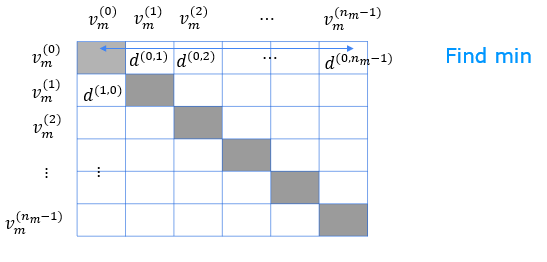

We can then find the closest movie by finding the minimum along each row. We will make use of [numpy masked arrays](https://numpy.org/doc/1.21/user/tutorial-ma.html) to avoid selecting the same movie. The masked values along the diagonal won't be included in the computation.

In [ ]:
count = 50
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])

m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    genre1,_  = get_item_genre(item_vecs[i,:], ivs, item_features)
    genre2,_  = get_item_genre(item_vecs[min_idx,:], ivs, item_features)

    disp.append( [movie_dict[movie1_id]['title'], genre1,
                  movie_dict[movie2_id]['title'], genre2]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
table

The results show the model will suggest a movie from the same genre.

<a name="4"></a>
## 4 - Congratulations!
You have completed a content-based recommender system.    

This structure is the basis of many commercial recommender systems. The user content can be greatly expanded to incorporate more information about the user if it is available.  Items are not limited to movies. This can be used to recommend any item, books, cars or items that are similar to an item in your 'shopping cart'.